In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['export OPENBLAS_NUM_THREADS']='1'

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam   

import matplotlib.pyplot as plt

import pickle

import firedrake
import icepack
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
import icepack.models.friction
import icepack.plot
from firedrake import sqrt, inner
from firedrake import div
import tqdm as notebook_tqdm
import numpy as np
from firedrake import conditional

import math
from scipy.stats import multivariate_normal

torch.manual_seed(0)
np.random.seed(0)

/home/ak2152@ad.eng.cam.ac.uk/firedrake/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(13, self.width)
        # self.fc0 = nn.Linear(5, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [3]:
################################################################
# Firedrake Icepack solver
################################################################
def acc_rates(acc_rate_mean, acc_rate_cov):
    Lx, Ly = 50e3, 12e3
    nx, ny = 48, 32
    mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

    Q = firedrake.FunctionSpace(mesh, "CG", 2)
    V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

    x, y = firedrake.SpatialCoordinate(mesh)
    xfunc = firedrake.interpolate(x, Q)
    yfunc = firedrake.interpolate(y, Q)

    b_in, b_out = 200, -400
    sol_index = 0

    b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

    s_in, s_out = 850, 50
    s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

    h0 = firedrake.interpolate(s0 - b, Q)

    h_in = s_in - b_in
    δs_δx = (s_out - s_in) / Lx
    τ_D = -ρ_I * g * h_in * δs_δx
    # print(f"{1000 * τ_D} kPa")

    u_in, u_out = 20, 2400
    velocity_x = u_in + (u_out - u_in) * (x / Lx) ** 2

    u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

    T = firedrake.Constant(255.0)
    A = icepack.rate_factor(T)

    expr = (0.95 - 0.05 * x / Lx) * τ_D / u_in**(1 / m)
    C = firedrake.interpolate(expr, Q)

    p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
    p_I = ρ_I * g * h0
    ϕ = 1 - p_W / p_I

    def weertman_friction_with_ramp(**kwargs):
        u = kwargs["velocity"]
        h = kwargs["thickness"]
        s = kwargs["surface"]
        C = kwargs["friction"]

        p_W = ρ_W * g * firedrake.max_value(0, h - s)
        p_I = ρ_I * g * h
        ϕ = 1 - p_W / p_I
        return icepack.models.friction.bed_friction(
            velocity=u,
            friction=C * ϕ,
        )

    model_weertman = icepack.models.IceStream(friction=weertman_friction_with_ramp)
    opts = {"dirichlet_ids": [1], "side_wall_ids": [3, 4]}
    solver_weertman = icepack.solvers.FlowSolver(model_weertman, **opts)

    u0 = solver_weertman.diagnostic_solve(
        velocity=u0, thickness=h0, surface=s0, fluidity=A, friction=C
    )

    # Basal shear stress plot
    expr = -1e3 * C * ϕ * sqrt(inner(u0, u0)) ** (1 / m - 1) * u0
    τ_b = firedrake.interpolate(expr, V)

    # Mass flux plot
    f = firedrake.interpolate(-div(h0 * u0), Q)

    # Take initial glacier state and project it forward until it reaches a steady state
    num_years = 250
    timesteps_per_year = 2 # 6 months

    δt = 1.0 / timesteps_per_year
    num_timesteps = num_years * timesteps_per_year

    # (2) Gaussian distribution
    # mu, sigma = acc_rate_mean, 0.1 #1.5, 1

    # (2) Gaussian distribution
    # expr =  conditional(x / Lx > 0, np.random.normal(mu, sigma), 0) - conditional(x / Lx > 0.5, 1.0, 0.0)  

    # Constant
    # expr =  firedrake.Constant(np.max(0.5,np.mean(acc_rate_mean))) - conditional(x / Lx > 0.5, 1.0, 0.0)  

    # expr =   - conditional(x / Lx > 0.5, 1.0, 0.0)  
    # a = firedrake.interpolate(expr, Q)

    # Define symbolic variables and functions
    # mu1, mu2 = 3.0, 0.6
    # acc_rate_mean = np.array([mu1, mu2])
    sigma1, sigma2 = acc_rate_cov[0], acc_rate_cov[1]
    rho = 0
    scale = 10000
    
    mu = firedrake.Constant(acc_rate_mean) #firedrake.Constant(np.array([mu1, mu2]))
    sigma = firedrake.Constant(np.array([[sigma1**2, rho*sigma1*sigma2], [rho*sigma1*sigma2, sigma2**2]]))
    x, y = firedrake.SpatialCoordinate(mesh)
    u = firedrake.Function(Q)
    gauss_expr = (2*np.pi)**(-1)*firedrake.det(sigma)**(-0.5)*firedrake.exp(-0.5*firedrake.dot(firedrake.as_vector([x/scale, y/scale])-mu, firedrake.inv(sigma)*(firedrake.as_vector([x/scale, y/scale])-mu)))
    
    # Define Gaussian function
    # f = u.interpolate(gauss_expr)
    a = firedrake.interpolate(gauss_expr, Q)

    # # Define means and covariance matrix
    # mu1, mu2 = 3.0, 0.6
    # sigma1, sigma2 = 0.5, 0.2
    # rho = 0
    # mean = np.array([mu1, mu2])
    # cov = np.array([[sigma1**2, rho*sigma1*sigma2], [rho*sigma1*sigma2, sigma2**2]])

    # # Create multivariate Gaussian distribution object
    # dist = multivariate_normal(mean=mean, cov=cov)
    
    
    # f = np.array([dist.pdf([xi/scale, yi/scale]) for xi, yi in zip(xfunc.dat.data, yfunc.dat.data)])

    # # Create a function in the function space that represents the distribution
    # a = firedrake.Function(V)

    # a.dat.data[:,0] = f.T
    # f_interp = firedrake.interpolate(f_func, Q)

    # cp = plt.scatter(xfunc.dat.data/scale, yfunc.dat.data/scale, c=a.dat.data)
    # plt.colorbar(cp)
    # plt.savefig("firefigs/inverse/fno_training/data/constant/multivariate.png")
    # plt.close()

    h = h0.copy(deepcopy=True)
    u = u0.copy(deepcopy=True)

    ice_stream_sol = np.zeros((65,97,20))
    # ice_stream_sol = np.zeros((65,97,10))
    i = 0
    for step in range(num_timesteps):
        # if step == 226:
        #     break
        
        h = solver_weertman.prognostic_solve(
            δt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h0,
        )
        s = icepack.compute_surface(thickness=h, bed=b)

        u = solver_weertman.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )
        if step%25==0:
        # if step == 0 or step == 25:
            
            # Velocity
            test = np.vstack((xfunc.dat.data, yfunc.dat.data, u.dat.data[:,0])).T
            test = test[(-test[:,1]).argsort()]
            test = test.reshape((65,97,3))
            for j in range(65):
                curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
                curr = curr[curr[:,0].argsort()]
                curr = curr.T
                test[j,:,0] = curr[0,:]
                test[j,:,1] = curr[1,:]
                test[j,:,2] = curr[2,:]
            ice_stream_sol[:,:,i]  = test[:,:,2]
            i+=1
            
            # plt.clf()
            # cp = plt.imshow(test[:,:,2])
            # plt.colorbar(cp)
            # plt.savefig(f"firefigs/inverse/fno_training/data/constant/multivariate_{step}.png")
            # plt.close()
    
    # test = np.vstack((xfunc.dat.data, yfunc.dat.data, h.dat.data)).T
    # test = test[(-test[:,1]).argsort()]
    # test = test.reshape((65,97,3))
    # for j in range(65):
    #     curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
    #     curr = curr[curr[:,0].argsort()]
    #     curr = curr.T
    #     test[j,:,0] = curr[0,:]
    #     test[j,:,1] = curr[1,:]
    #     test[j,:,2] = curr[2,:]
    # ice_stream_sol[:,:,i]  = test[:,:,2]
    # i+=1
    # np.save(f"firefigs/inverse/fno_training/data/constant/observed_multivar.npy", ice_stream_sol)
    return ice_stream_sol

In [4]:
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [5]:
def fourier(acc_rates_mean):
    ################################################################
    # configs
    ################################################################
    S1 = 65
    S2 = 97
    T_in = 10
    T = 10
    step = 1
    ################################################################
    # load data
    ################################################################
    # data = torch.tensor(acc_rates(acc_rates_mean[0]), dtype=torch.float)
    data = torch.tensor(acc_rates(acc_rates_mean, 0), dtype=torch.float)

    a_normalizer = 0
    # Load the object from the file
    with open('a_normalizer_multivar.pkl', 'rb') as f:
        a_normalizer = pickle.load(f)

    y_normalizer = 0
    # Load the object from the file
    with open('y_normalizer_multivar.pkl', 'rb') as f:
        y_normalizer = pickle.load(f)

    data = a_normalizer.encode(data)

    device = torch.device('cuda')

    data_ready = data.reshape(S1,S2,1,T_in).repeat([1,1,1,T,1])
    ################################################################
    # prediction
    ################################################################
    # model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')
    # myloss = LpLoss(size_average=False)
    y_normalizer.cuda()

    pred = torch.zeros(10, S1, S2, 10)

    index = 0
    model = torch.load("/home/ak2152@ad.eng.cam.ac.uk/mnt/Code/fourier_neural_operator-master/model/acc_rate3d_mutlivar_ep100_Tin10", map_location=device)
    test_loader = torch.utils.data.DataLoader(data_ready, batch_size=1, shuffle=False)

    with torch.no_grad():
        for x in test_loader:
            x = x.cuda()
            out = model(x)
            out = y_normalizer.decode(out[:,:,:,0])
            pred[index] = out
            return pred[index].numpy()

In [6]:
################################################################
# MCMC
################################################################
# y: observed data = noisy data with accumulation rate 1.5
# f: predicted data = data with various accumulation rates used to train the fno 

def rel(x, y):
    l = x.shape[0]*x.shape[1]
    # L2 norm
    diff_norms = np.linalg.norm(x.reshape((1,l)) - y.reshape((1,l)))
    # y_norms = np.linalg.norm(y.reshape((1,l)))
    # print(diff_norms/y_norms)
    # return diff_norms/y_norms
    return diff_norms


def log_likelihood(y, f, sigma):
    l2_total = 0

    N = f.shape[2] # f.shape[1]
    M = 1 #y.shape[3]
    for j in range(M):
        for i in range(N):
            # l2_total = l2_total + math.pow(rel(y[:,:,i,j], f[:,:,i]),2)
            l2_total = l2_total + math.pow(rel(y[:,:,i], f[:,:,i]),2)
    
    scale = 1 #0.000001
    return -0.5*l2_total/(M*N*math.pow(sigma,2))*scale

def pcn(N, u0, y, n_iters, beta, Kc, sigma):
    """ pCN MCMC method for sampling from pdf defined by log_prior and log_likelihood.
    Inputs:
        log_likelihood - log-likelihood function
        u0 - initial sample
        y - observed data
        n_iters - number of samples
        beta - step-size parameter
    Returns:
        X - samples from target distribution
        acc/n_iters - the proportion of accepted samples"""

    target_acceptance_rate = 0.25
    tuning_parameter = 0.01
    X = []
    acc = 0
    u_prev = u0
    # print(f"Initial proposal: {u_prev}")

    # replace with operator
    f = acc_rates(u_prev[:2], u_prev[2:])
    # f = fourier(u_prev)

    ll_prev = log_likelihood(y, f, sigma)
    # print(f"log-likelihood initial is: {ll_prev}")
    

    for i in notebook_tqdm.trange(n_iters):
        # z = np.random.randn(N, )
        z = np.random.randn(N)
        u_new = np.sqrt(1 - pow(beta, 2)) * u_prev + beta * Kc @ z # Propose new sample using pCN proposal
        # Add positive constraint for mean and std
        u_new[u_new < 0] = 0.01
        # print(f"Proposal: {u_new}")

        # replace with operator
        f = acc_rates(u_new[:2], u_new[2:])
        # f = fourier(u_new)

        ll_new = log_likelihood(y, f, sigma)
        # print(f"log-likelihood new is: {ll_new}")

        # Calculate pCN acceptance probability
        log_alpha = min(0, ll_new-ll_prev) 
        # print(f"Acceptance probability:{np.exp(log_alpha)}")
        # print(f"Log-alpha is: {log_alpha}")
        log_u = np.log(np.random.random())
        # print(f"Log-u is: {log_u}")

        # Accept/Reject
        accept = log_u<=log_alpha # Compare log_alpha and log_u to accept/reject sample (accept should be boolean)
        if accept:
            acc += 1
            X.append(u_new)
            u_prev = u_new
            ll_prev = ll_new
            # print("Accepted")
        else:
            X.append(u_prev)
            # print("Rejected")
        
        beta = max(beta + tuning_parameter * (acc / (i+1) - target_acceptance_rate), 0.01)
        # print(f"step size is: {beta} and acceptance rate is {acc / (i+1)}")
    return X, acc / n_iters

In [7]:
# # Load noisy data
y = np.load("/home/ak2152@ad.eng.cam.ac.uk/mnt/observed_multivar.npy")
observed_data = y #y[:,:,10:] #y[:,:,10:,:]

# Set Gaussian prior around true accumulation rates
# Covariance
true_acc_rate = [2, 2, 0.8, 0.5] #3.0 #1.5
N = 4
K = np.diag(true_acc_rate)

#  z = np.random.randn(N, )
z = np.random.randn(N)
# Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
Kc = np.linalg.cholesky(K)

# Sample from Gaussian prior to initialize MCMC
u0 = Kc @ z
u0[u0 < 0] = 0.01
# Set number of iterations  and step size beta
n_iters = 1500
beta = 0.2

# Likelihood variance
sigma = 1

# Run MCMC
pcn_u, pcn_acc = pcn(N, u0, observed_data, n_iters, beta, Kc, sigma)
pcn_u = np.array(pcn_u)
np.save("/home/ak2152@ad.eng.cam.ac.uk/mnt/mcmc_samples_2d_solver.npy", pcn_u)
print(pcn_acc)
# print(np.mean(pcn_u))

  4%|▎         | 55/1500 [1:36:39<42:19:17, 105.44s/it]


KeyboardInterrupt: 

(350, 4)
Mean : 2.71057349783564 , 0.40664141677120286
Mean (burn-in 100) : 2.7754410411163692 , 0.48260165775169533
Std : 0.3335834577686154 , 0.8400406969253045


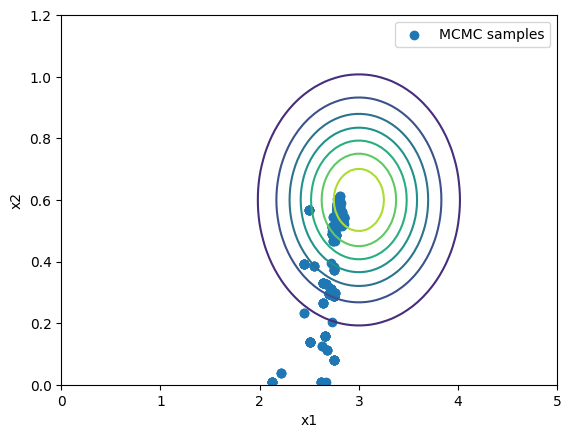

In [ ]:
# ### Plot MCMC
data = np.load("/home/ak2152@ad.eng.cam.ac.uk/mnt/mcmc_samples_2d_solver.npy")
print(data.shape)
mu1_data = data[:,0]
mu2_data = data[:,1]
sigma1_data = data[:,2]
sigma2_data = data[:,3]

print(f"Mean : {np.mean(mu1_data)} , {np.mean(mu2_data)}")
print(f"Mean (burn-in 100) : {np.mean(mu1_data[100:])} , {np.mean(mu2_data[100:])}")

print(f"Std : {np.mean(sigma1_data)} , {np.mean(sigma2_data)}")

mu1, mu2 = 3.0, 0.6
sigma1, sigma2 = 0.5, 0.2
mu = np.array([mu1, mu2])       # mean
cov = np.array([[sigma1**2, 0], [0, sigma2**2]])  # covariance matrix

# with given mean and covariance matrix
distr = multivariate_normal(cov = cov, mean = mu,)
    
# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = mu[0], mu[1]
sigma_1, sigma_2 = 0.5, 0.2
    
x = np.linspace(0, 5, num=97)
y = np.linspace(0, 1.2, num=65)
X, Y = np.meshgrid(x,y)
    
# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# Mu1
# plt.plot(data[:,0], label="mean mu1")
# plt.axhline(y=mu1, color='blue', linestyle='dotted')

# # Mu2
# plt.plot(data[:,1], label="mean mu2")
# plt.axhline(y=mu2, color='orange', linestyle='dotted')

# # Sigma 1
# plt.plot(data[:,2], label="sigma 1")
# plt.axhline(y=sigma1, color='green', linestyle='dotted')

# # Sigma 2
# plt.plot(data[:,3], label="sigma 2")
# plt.axhline(y=sigma2, color='red', linestyle='dotted')

# plt.ylabel("Parameters")
# plt.xlabel("Iteration")

plt.scatter(mu1_data, mu2_data, label="MCMC samples")
plt.contour(X, Y, pdf, cmap='viridis')
plt.ylabel("x2")
plt.xlabel("x1")
plt.legend()
plt.show()